This file includes code to produce figures 2 and 3. 

## Figure 2

This code reproduces the velocity distribution for the static and evolved models, and the ratio of MW to LMC particles in each bin 

In [1]:
# basic imports
import os
import numpy as np
from numpy.linalg import eig, inv
import scipy.stats as stats
from scipy.stats import maxwell
import math
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import FormatStrFormatter

In [2]:
# If the data files are in a location other than the current directory, set the
# environment variable DATA_FILE_PATH to that location
data_file_path = (os.environ.get('DATA_FILE_PATH') or '.') + os.path.sep

In [3]:
# set default plot parameters 
cmap = cm.RdBu_r

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['font.family'] = 'Times New Roman'
hfont = {'fontname':'Times New Roman'}

In [4]:
def quick_hist(vtot,bins = np.linspace(0,800,25)):
    """create a histogram with the area under the graph 
       normalised to one
    """
    
    bbins = bins + 0.5*(bins[1]-bins[0])
    vals = np.zeros_like(bins)
    for b in range(0,bins.size-1):
        w = np.where( (vtot>=bins[b]) & (vtot<bins[b+1]))[0]
        vals[b] = w.size
        
    # normalise the area to one
    db = bbins[1]-bbins[0]
    norm = np.nansum(db*vals)
    
    return bbins,vals/norm

def sky_hist_2d(x,y,xbins,ybins,weights=None,sky=True):
    """2d histogram for the surface of a sphere (aka the sky)
       if sky=True, the returned map is normalised by the area 
       of each pixel to correct for geometric effects
    """
    
    # get X and Y as matrices 
    X,Y = np.meshgrid(xbins,ybins)
    
    if weights is None:
        weights = np.ones(x.size)
           
    dx = np.abs(xbins[1]-xbins[0])
    dy = np.abs(ybins[1]-ybins[0])
    img = np.zeros([xbins.size,ybins.size])
    Nxindx = (np.round((x - np.nanmin(xbins))/(dx))).astype('int')
    Nyindx = (np.round((y - np.nanmin(ybins))/(dy))).astype('int')

    # loop through bins
    for xval in range(0,xbins.size):
        for yval in range(0,ybins.size):
            w = np.where((Nxindx==xval) & (Nyindx==yval))[0]
            if len(w) > 0:
                img[xval,yval] += np.nansum(weights[w])
                
    if sky:
        return X,Y,img.T/np.cos(Y*np.pi/180.)
    else:
        return X,Y,img.T
    

In [5]:
def weighted_pdf(vtot, weights, bins = np.linspace(0,800,25), normalised = True):
    
    """make a quick 1D pdf, with weights"""
    
    bin_width = bins[1] - bins[0]
    bbins = bins + 0.5 * bin_width
    bbins = bbins[0:-1]
    vals = np.zeros_like(bins[0:-1])
    
    # increase the value of the upper boundary to ensure we include any values equal to the upper boundary
    bins[-1] += 0.1
    
    for b in range(0,bins.size - 1):
        indexes_of_values_in_bin = np.where( (vtot >= bins[b]) & (vtot < bins[b+1]))[0]
        vals[b] = np.nansum(weights[indexes_of_values_in_bin])
    
    if normalised == True:
        # normalise the area to one
        norm = np.nansum(vals)
        vals = vals/norm

    return bbins,vals

def weighted_cdf(vtot,weights,bins = np.linspace(0,800,25)):
    
    """make a quick 1D cdf, with weights"""
    
    bbins = bins + 0.5*(bins[1]-bins[0])
    vals = np.zeros_like(bins)
    
    for b in range(0,bins.size-1):
        w = np.where((vtot<bins[b+1]))[0]
        vals[b] = np.nansum(weights[w])
    
    # normalise the area to one
    db = bbins[1]-bbins[0]
    norm = np.nanmax(vals)
    
    return bbins,vals/norm

In [6]:
#all of the data is in the heliocentric reference frame
frame = 'heliocentric'

# LMC radius is 3 kpc
LMC_radius = 3000

# MW radius is 2 kpc
MW_radius = 2000

#conversion from M_sun/pc^3 to GeV/cm^3
msunpc3_to_gevcm3 = 37.96


#this runtag is specific to the data provided that corresponds to an NFW density profile for both the MW and LMC
runtag = 'system1_3eb'

model_lmc_evolved = np.genfromtxt(data_file_path + '/LMC.evolved.' +frame + '.solar.' +runtag, delimiter=';',skip_header=1)
model_lmc_static = np.genfromtxt(data_file_path + '/LMC.static.' +frame+ '.solar.' +runtag, delimiter=';',skip_header=1)
model_mw_evolved = np.genfromtxt(data_file_path + '/MW.evolved.' +frame+ '.solar.' +runtag, delimiter=';',skip_header=1)
model_mw_static = np.genfromtxt(data_file_path + '/MW.static.' +frame+ '.solar.' +runtag, delimiter=';',skip_header=1)

# to get the total mass in the solar neighbourhood:
# - multiply a generic distribution: (total system mass)*(per particle mass)
# - multiply LMC distributions by 0.25 * 1.e12 * 9.166667e-09 = 
mlmc_scale = 0.25 * 1.e12 * 9.166667e-09
# - multiply MW distributions by 1.e12 * 2.75e-08 = 
mmw_scale  = 1.e12 * 2.75e-08

solar_volume_lmc = (4/3)*np.pi*(LMC_radius**3) # now in 1/pc^3
solar_volume_mw  = (4/3)*np.pi*(MW_radius**3) # now in 1/pc^3

# this is in Msun/pc, to get GeV/cm^3, do the standard conversions
solar_volume_scaled_lmc = solar_volume_lmc/msunpc3_to_gevcm3
solar_volume_scaled_mw  = solar_volume_mw/msunpc3_to_gevcm3


In [7]:
def calculate_weights(model, mass_scaled, volume_scaled):
    
    """ Weight the data based on the number of particles to
        get the real unnormalised values"""
    
    # model is 2D data, with each row representing a particle. The number of particles is therefore the number of rows
    number_of_particles = np.shape(model)[0]

    solar_neighbourhood_mass = number_of_particles * mass_scaled
    solar_neighbourhood_density = solar_neighbourhood_mass / volume_scaled

    # create an array of the same size as the number of particles
    weight = solar_neighbourhood_density * np.ones(number_of_particles)

    return weight

def vector_velocity(model):
    
    """ Calculate the particle velocities
        index of velocity component in the x direction: 3
        index of velocity component in the y direction: 4
        index of velocity component in the z direction: 5
    """
    
    particle_velocities = np.sqrt(model[:,3]*model[:,3] + \
                                  model[:,4]*model[:,4] + \
                                  model[:,5]*model[:,5])
    return particle_velocities

def calculate_ratio(weight_mw, particle_velocities_mw, weight_lmc, particle_velocities_lmc):
    
    """ Calculate the ratio of the number of LMC particles to 
        the total number of (MW+LMC) particles in each bin of 
        the histogram"""

    particle_velocities_all = np.concatenate([particle_velocities_mw, particle_velocities_lmc])

    no_of_bins = 20

    # Weighted NFW pdf
    _, hist = weighted_pdf(particle_velocities_all,\
                           np.concatenate([weight_mw, weight_lmc]),\
                           bins = np.linspace(np.nanmin(particle_velocities_all),np.nanmax(particle_velocities_all),no_of_bins + 1),
                           normalised = True)

    #Weighted NFW cdf
    bins, hist_nfw_static = weighted_cdf(np.concatenate([particle_velocities_mw, particle_velocities_lmc]),\
                                         np.concatenate([weight_mw, weight_lmc]),\
                                         bins = np.linspace(np.nanmin(particle_velocities_all),np.nanmax(particle_velocities_all), 2001))


    bins_lmc, hist_to_get_scaled_no_of_particles_lmc = weighted_pdf(particle_velocities_lmc,
                                                                    weight_lmc,
                                                                    bins = np.linspace(np.nanmin(particle_velocities_all),np.nanmax(particle_velocities_all),no_of_bins + 1),
                                                                    normalised = False)
    
    bins_mw, hist_to_get_scaled_no_of_particles_mw = weighted_pdf(particle_velocities_mw,
                                                                  weight_mw,
                                                                  bins = np.linspace(np.nanmin(particle_velocities_all),np.nanmax(particle_velocities_all), no_of_bins + 1),
                                                                  normalised = False)

    ratio = (hist_to_get_scaled_no_of_particles_lmc) / (hist_to_get_scaled_no_of_particles_lmc + hist_to_get_scaled_no_of_particles_mw)
    
    return ratio, bins_mw


In [8]:
# get the weights for each model
weight_lmc_static = calculate_weights(model_lmc_static, mlmc_scale, solar_volume_scaled_lmc)
weight_lmc_evolved = calculate_weights(model_lmc_evolved, mlmc_scale, solar_volume_scaled_lmc)
weight_mw_static = calculate_weights(model_mw_static, mmw_scale, solar_volume_scaled_mw)
weight_mw_evolved = calculate_weights(model_mw_evolved, mmw_scale, solar_volume_scaled_mw)

# get the total velocities for each model 
particle_velocities_lmc_static = vector_velocity(model_lmc_static)
particle_velocities_lmc_evolved = vector_velocity(model_lmc_evolved)
particle_velocities_mw_static = vector_velocity(model_mw_static)
particle_velocities_mw_evolved = vector_velocity(model_mw_evolved)

In [9]:
# find the ratio of the number of LMC particles to the total number of (MW+LMC) particles 
# for the static and evolved models

static_ratio, bins_mw_static = calculate_ratio(weight_mw_static, particle_velocities_mw_static, weight_lmc_static, particle_velocities_lmc_static)

evolved_ratio, bins_mw_evolved = calculate_ratio(weight_mw_evolved, particle_velocities_mw_evolved, weight_lmc_evolved, particle_velocities_lmc_evolved)


In [10]:
def get_hist_and_density(model, mass_scale, solar_volume_scaled, particle_velocities):
    
    number_of_particles = np.shape(model)[0]
    solar_neighbourhood_mass = number_of_particles * mass_scale
    solar_neighbourhood_density = solar_neighbourhood_mass / solar_volume_scaled
    
    bins, hist = quick_hist(particle_velocities, bins = np.linspace(0,900,55))
    
    return solar_neighbourhood_density, bins, hist

Text(0, 0.5, 'n$_{LMC}$/(n$_{MW}$ + n$_{LMC}$)')

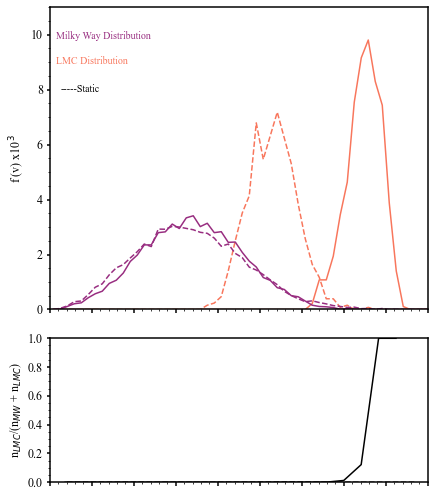

In [11]:

# set up the figure frame and specify figsize 
fig = plt.figure(figsize=(7,10))

ax1 = fig.add_axes([0.2,0.56,0.75,0.42])
ax2 = fig.add_axes([0.2,0.32,0.75,0.20])

mmax = 7 # how many models, -1, to get the colour range

#model_lmc_static
solar_neighbourhood_density, bins, hist = get_hist_and_density(model_lmc_static, \
                                                                 mlmc_scale, \
                                                                 solar_volume_scaled_lmc, \
                                                                 particle_velocities_lmc_static)
ax1.plot(bins, 1000. * hist, color=cm.magma((5)/mmax), linestyle = 'dashed')
ax1.text(15, 8.92, 'LMC Distribution'.format(solar_neighbourhood_density),color=cm.magma((5)/mmax),**hfont)   

#model_mw_static
solar_neighbourhood_density, bins, hist = get_hist_and_density(model_mw_static, \
                                                                 mmw_scale, \
                                                                 solar_volume_scaled_mw, \
                                                                 particle_velocities_mw_static)
ax1.plot(bins, 1000. * hist, color=cm.magma((3)/mmax), linestyle = 'dashed')
ax1.text(15, 9.85, 'Milky Way Distribution'.format(solar_neighbourhood_density),color=cm.magma((3)/mmax),**hfont)   



#model_lmc_evolved
solar_neighbourhood_density, bins, hist = get_hist_and_density(model_lmc_evolved, \
                                                                 mlmc_scale, \
                                                                 solar_volume_scaled_lmc, \
                                                                 particle_velocities_lmc_evolved)
ax1.plot(bins, 1000. * hist, color=cm.magma((5)/mmax))
ax1.text(25, 7.92,'-----Static'.format(solar_neighbourhood_density),color='Black',**hfont) 

#model_mw_evolved
solar_neighbourhood_density, bins, hist = get_hist_and_density(model_mw_evolved, \
                                                                 mmw_scale, \
                                                                 solar_volume_scaled_mw, \
                                                                 particle_velocities_mw_evolved)
ax1.plot(bins, 1000. * hist, color=cm.magma((3)/mmax))

#set axis range
ax1.axis([0.,900.,0.,11])
ax2.axis([0.,900.,0.,1.])

ax2.plot(bins_mw_evolved, evolved_ratio, color='black')
ax2.plot(bins_mw_static, static_ratio, color='black', linestyle = 'dashed')

ax1.set_xticklabels(())
ax2.set_xticklabels(())

ax1.set_ylabel('f (v) x10$^3$',size=12, **hfont)
ax2.set_ylabel('n$_{LMC}$/(n$_{MW}$ + n$_{LMC}$)',size=12, **hfont)

# OPTIONAL
# add in an extra plot to see the static ratio 
# ax3 = fig.add_axes([0.2,0.07,0.75,0.20])
# ax3.plot(bins_mw_static, static_ratio, color='black', linestyle = 'dashed')
# ax3.axis([0.,900.,0.,0.0016])
# ax3.set_ylabel('n$_{LMC}$/(n$_{MW}$ + n$_{LMC}$)',size=12, **hfont)
# ax3.set_xlabel('Velocity (km/s)',size=12, **hfont)


## Figure 3
Code to show the density plots of the evolved NFW model for MW, LMC, high velocity and (optionally) particles experiencing reflex motion

In [12]:
# Find centroid

# code snippets to make a draft figure showing how centroids move
# around on the sky as a function of a threshold velocity.

def haversine(lon1, lat1, lon2, lat2,deg=True):
    """
    Calculate the great circle distance between two points 
    on a sphere (specified in decimal degrees or radians)
    """
    # convert decimal degrees to radians 
    if deg:
        lon1, lat1, lon2, lat2 = (np.pi/180.)*lon1, (np.pi/180.)*lat1, (np.pi/180.)*lon2, (np.pi/180.)*lat2

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2. * np.arcsin(np.sqrt(a)) 
    if deg:
        return (180./np.pi)*c
    else:
        return c
    

def find_median_particle(velp,velt,tvel,vthreshold=600,tolerance=50.,error=False):
    """
    find the particle from a distribution that has the smallest median separation to all other particles:
    i.e. the central particle

    inputs
    -----------------
    velp       : the phi velocities
    velt       : the theta velocities
    tvel       : the total velocities
    vthreshold : the threshold velocity
    tolerance  : what fraction of particles to use for centroid
    errror     : calculate and return bootstrap errors?
    """
    
    # subselect particles that are above the velocity threshold
    use    = tvel > vthreshold
    vphi   = velp[use]
    vtheta = velt[use]
    
    # set up the array of separations, filled with maximum separations
    meandist = np.zeros(vphi.size) + np.pi
    
    for p in range(0,vphi.size):

        # compute the separations to all particles
        separations = haversine(vphi[p],vtheta[p],vphi,vtheta,deg=False)
        
        # compute the desired separation value (in fractions of the total number of particles)
        meandist[p] = np.nanpercentile(separations,tolerance)
        
    # one option is to randomly drop some fraction of the particles and see how much the centroid changes
    # a monte-carlo style error estimation
    if error:
        # how many samples?
        prefac = 1
        bootstrapsqrt = prefac*int(np.sqrt(meandist.size))
        centre1,centre2 = np.zeros(bootstrapsqrt),np.zeros(bootstrapsqrt)
        for n in range(0,bootstrapsqrt):
            nselect = np.random.randint(0,meandist.size,bootstrapsqrt)
            #print(meandist[nselect])
            w = np.nanargmin(meandist[nselect])
            centre1[n],centre2[n] = vphi[nselect[w]],vtheta[nselect[w]]            

    # this is the radius of the circle that encompasses the desired fraction of particles
    #print(180.*np.nanmin(meandist)/np.pi)
    # this could be used as a measure of the uncertainty? (or some fraction of this)
    
    # which particle is the centroid particle?
    w = np.nanargmin(meandist)
    
    # print the centroid
    #print(velp[w],velt[w])
    cov = (prefac)*np.cov([centre1,centre2])
    #print(cov)
    xerr,yerr = np.sqrt(cov[0][0]),np.sqrt(cov[1][1])
    corr = cov[0][1]/(xerr*yerr)
    #print('correlation:',corr)
    
    # to get a 95% confidence ellipse, multiply xerr and yerr by 2.4477 (chi^2 distribution prefactor)

    # return the centroid
    if error:
        return vphi[w],vtheta[w],xerr,yerr,corr
    else:
        return vphi[w],vtheta[w]


def make_error_bars(ax,x,y,ex,ey,xyc,color='black'):
    """helper function to generate error ellipse bars on a plot
    
    takes output of find_median_particle plus the axis that the bars
    will be plotted on (and the color)


    """
    rotation_angle = 0.5*np.arctan(2*xyc*ex*ey/(ex**2 + ey**2))
    # first the 'x' error bars
    x1,x2,y1,y2 = -ex,ex,0,0
    x1p,y1p = np.dot([x1,y1],[[np.cos(rotation_angle),-np.sin(rotation_angle)],\
                              [np.sin(rotation_angle), np.cos(rotation_angle)]])
    x2p,y2p = np.dot([x2,y2],[[np.cos(rotation_angle),-np.sin(rotation_angle)],\
                              [np.sin(rotation_angle), np.cos(rotation_angle)]])    
    ax.plot([x+x1p,x+x2p],[y+y1p,y+y2p],color=color,lw=2.)
    
    # now the 'y' error bars
    x1,x2,y1,y2 = 0,0,-ey,ey
    #rotation_angle *= 0.5 # spherical convention
    x1p,y1p = np.dot([x1,y1],[[np.cos(rotation_angle),-np.sin(rotation_angle)],\
                              [np.sin(rotation_angle), np.cos(rotation_angle)]])
    x2p,y2p = np.dot([x2,y2],[[np.cos(rotation_angle),-np.sin(rotation_angle)],\
                              [np.sin(rotation_angle), np.cos(rotation_angle)]])    
    ax.plot([x+x1p,x+x2p],[y+y1p,y+y2p],color=color,lw=2.)



In [13]:
# bring in MW, LMC

runtag = 'system2_3eb'
# second file: evolved MW particles
model_mw_evolved  = np.genfromtxt(data_file_path + '/MW.evolved.heliocentric.solar.' +runtag,delimiter=';',skip_header=1)
model_lmc_evolved = np.genfromtxt(data_file_path + '/LMC.evolved.heliocentric.solar.' +runtag,delimiter=';',skip_header=1)

# create velocity transformations
MWvp = np.arctan2(-model_mw_evolved[:,4],-model_mw_evolved[:,3])
MWvt = np.arctan(-model_mw_evolved[:,5]/np.sqrt(model_mw_evolved[:,3]**2 + model_mw_evolved[:,4]**2))
MWtv = np.sqrt(model_mw_evolved[:,3]**2 + model_mw_evolved[:,4]**2 + model_mw_evolved[:,5]**2.)
LMCvp = np.arctan2(-model_lmc_evolved[:,4],-model_lmc_evolved[:,3])
LMCvt = np.arctan(-model_lmc_evolved[:,5]/np.sqrt(model_lmc_evolved[:,3]**2 + model_lmc_evolved[:,4]**2))
LMCtv = np.sqrt(model_lmc_evolved[:,3]**2 + model_lmc_evolved[:,4]**2 + model_lmc_evolved[:,5]**2.)

In [14]:
"""
annual modulation testing
"""

def return_v_earth(t,v_earth=29.8,\
                     e1=np.array([ 0.9931,0.1170,-0.0103]),\
                     e2=np.array([-0.0670,0.4927,-0.8676]),\
                     omega=2*np.pi,\
                     t1=0):
    """
    Kelso+ (2016) 4.9
    omega is in units per year
    """
    vx = v_earth*(e1[0]*np.cos(omega*(t-t1)) + e2[0]*np.sin(omega*(t-t1)))
    vy = v_earth*(e1[1]*np.cos(omega*(t-t1)) + e2[1]*np.sin(omega*(t-t1)))
    vz = v_earth*(e1[2]*np.cos(omega*(t-t1)) + e2[2]*np.sin(omega*(t-t1)))
   
    return vx,vy,vz


In [15]:
def annual_modulation_contour(model_evolved, axes, f, phi_res, th_res, dg, linewidths, levels, linestyles='solid'):
    
    """ Plot a solid and dashed line to demonstrate the change in directionality due to annual modulation"""
    
    # create velocity transformations to measure the centroid position for the month (June or December)
    vx, vy, vz = return_v_earth(f)
    xvel = model_evolved[:,3] + vx
    yvel = model_evolved[:,4] + vy
    zvel = model_evolved[:,5] + vz

    velp = np.arctan2(-yvel, -xvel)
    velt = np.arctan(-zvel/np.sqrt(xvel**2 + yvel**2))
    tvel = np.sqrt(xvel**2 + yvel**2 + zvel**2)

    # get the density plot as a 2D histogram on the sky for the month (June or December)
    X, Y, img_ZL = sky_hist_2d(velp, velt, phi_res, th_res)

    #plot just one contour to demonstrate the difference due to annual modulaton
    axes.contour(-X, Y, (img_ZL)/dg, [0.05,1.], levels = levels, colors='black',linewidths=linewidths, linestyles=linestyles)


def plot_density(model_evolved, axes, title, phi_res, th_res, dg, ddeg_amc, levels=None):
    
    """ Create the density plot"""

    # create velocity transformations
    velp = np.arctan2(-model_evolved[:,4],-model_evolved[:,3])
    velt = np.arctan(-model_evolved[:,5]/np.sqrt(model_evolved[:,3]**2 + model_evolved[:,4]**2))
    tvel = np.sqrt(model_evolved[:,3]**2 + model_evolved[:,4]**2 + model_evolved[:,5]**2.)

    # create the density plot as a 2D histogram
    X, Y, img_ZL = sky_hist_2d(velp, velt, phi_res, th_res)
    axes.pcolormesh(-X, Y,(img_ZL) / dg, cmap=cm.Reds,shading='auto')
    axes.set_title(title, y = 1.08)

    # Get the centroid point and error bars for the particles
    x, y, ex, ey, xyc = find_median_particle(velp, velt, tvel, vthreshold=0, tolerance=50., error=True)
    make_error_bars(axes,-x, y, 2.44 * ex, 2.44 * ey, xyc, color='white')

    #ANNUAL MODULATION CONTOURS
    phi_res_amc, th_res_amc, dg_amc = calculate_res(ddeg_amc)
    
    annual_modulation_contour(model_evolved, axes, 5./12., phi_res_amc, th_res_amc, dg_amc, linewidths=1., levels=levels) # June
    annual_modulation_contour(model_evolved, axes, 11./12., phi_res_amc, th_res_amc, dg_amc, linewidths=0.5, levels=levels, linestyles='dashed') # December
    
    return velp, velt, tvel

In [16]:
def calculate_res(ddeg):
    
    """ Get the resolution of the graph """
    
    dg_local = ddeg*ddeg
    phi_res = (np.arange(-180,180,ddeg)+ddeg/2.)/rad_to_deg
    th_res  = (np.arange(-90,90,ddeg)+ddeg/2.)/rad_to_deg
    
    return phi_res, th_res, dg_local

In [17]:
# Models for the contour plots
model_mw_evolved = np.genfromtxt(data_file_path + '/MW.evolved.heliocentric.solar.system1_3eb',delimiter=';',skip_header=1)
model_lmc_evolved = np.genfromtxt(data_file_path + '/LMC.evolved.heliocentric.solar.system1_3eb',delimiter=';',skip_header=1)

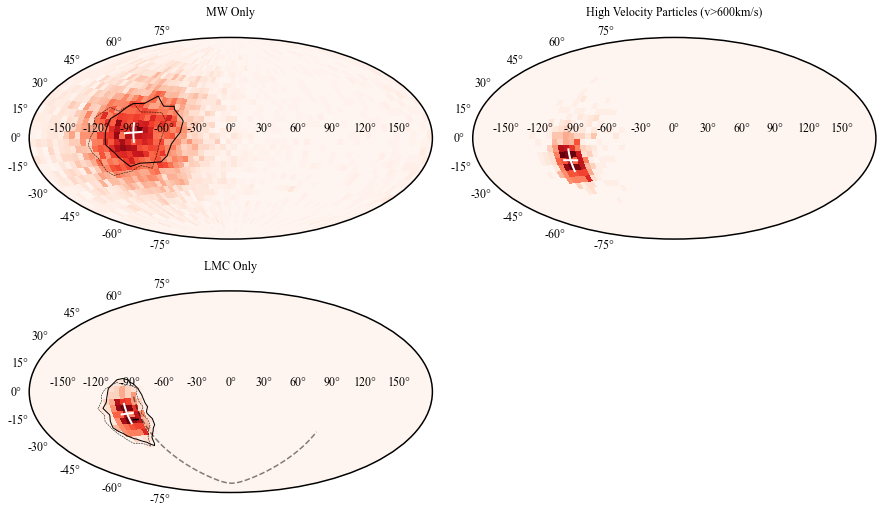

In [18]:
# Make the contour plots

fig = plt.figure(figsize=(14,8))

xmin = 0.1
ymin = 0.1
dx = 0.4
dy = 0.4

ax1 = fig.add_axes([xmin, ymin+dy, dx, dy], projection="aitoff") # upper left
ax2 = fig.add_axes([xmin, ymin-0.04, dx, dy], projection="aitoff") # lower left
ax3 = fig.add_axes([xmin+dx+0.04, ymin+dy, dx, dy], projection="aitoff") # upper right


viridis = cm.get_cmap('viridis', 12)

# velocities get reversed, because we want to know where they came from.
rad_to_deg = 180./np.pi

# decide on resolution on the sky 
phi_res, th_res, dg = calculate_res(ddeg=5)

# -----------------------------------------------------------------------------------------
# Top left - MW Only
velp_mw, velt_mw, tvel_mw = plot_density(model_mw_evolved, ax1, 'MW Only', phi_res, th_res, dg, ddeg_amc=10, levels=[1])


# -----------------------------------------------------------------------------------------
# Bottom left - LMC Only
velp_lmc, velt_lmc, tvel_lmc = plot_density(model_lmc_evolved, ax2, 'LMC Only', phi_res, th_res, dg, ddeg_amc=5)


# Add trajectory to LMC Only contour plot
A = np.genfromtxt(data_file_path + '/trajectory.system1_3eb.txt')
ax2.plot(-A[:,1],A[:,2],color='black',alpha=0.5, linestyle = 'dashed')


# -----------------------------------------------------------------------------------------
# Top right - the high velocity MW and LMC particles in the evolved NFW model

#set a high velocity threshold
vthresh = 600

velp_mw_and_lmc = np.hstack((velp_mw,velp_lmc))
velt_mw_and_lmc = np.hstack((velt_mw,velt_lmc))
tvel_mw_and_lmc = np.hstack((tvel_mw,tvel_lmc))

# create velocity transformations
velp_hv = velp_mw_and_lmc[tvel_mw_and_lmc > vthresh]
velt_hv = velt_mw_and_lmc[tvel_mw_and_lmc > vthresh]
tvel_hv = tvel_mw_and_lmc[tvel_mw_and_lmc > vthresh]

#create the density plot as a 2D histogram
X_hv,Y_hv,img_ZL_hv = sky_hist_2d(velp_hv,velt_hv,phi_res,th_res)
ax3.pcolormesh(-X_hv,Y_hv,(img_ZL_hv)/dg,cmap=cm.Reds,shading='auto')
ax3.set_title('High Velocity Particles (v>600km/s)', y = 1.08)

#Get the centroid point and error bars for the particles
x_hv,y_hv,ex_hv,ey_hv,xyc_hv = find_median_particle(velp_hv,velt_hv,tvel_hv,vthreshold=600,tolerance=50.,error=True)
make_error_bars(ax3,-x_hv,y_hv,2.44*ex_hv,2.44*ey_hv,xyc_hv,color='white')


# -----------------------------------------------------------------------------------------
# OPTIONAL 

# Bottom right - the particles that experience reflex motion in the evolved MW for NFW model

#ax4 = fig.add_axes([xmin+dx+0.04, ymin-0.04, dx, dy], projection="aitoff") # lower right

#phi_res, th_res, dg = calculate_res(ddeg=7)

#large apocentre mask
#runtag = 'system1_3eb'
#C1 = np.genfromtxt(data_file_path + '/maxrapo.1.'+runtag)
#r_apo = C1[:,0]
#large_r_apo_mask = (r_apo * 300) > 40

# create velocity transformations
#velp_ref = velp_mw[large_r_apo_mask]
#velt_ref = velt_mw[large_r_apo_mask]
#tvel_ref = tvel_mw[large_r_apo_mask]

#create the density plot as a 2D histogram
#X_ref,Y_ref,img_ZL_ref = sky_hist_2d(velp_ref,velt_ref,phi_res,th_res)
#ax4.pcolormesh(-X_ref,Y_ref,(img_ZL_ref)/dg,cmap=cm.Reds, shading='auto')
#ax4.set_title('Large Apocentre Particles (R$_{apo}$ > 40)', y = 1.08)

#Get the centroid point and error bars for the particles
#x_ref,y_ref,ex_ref,ey_ref,xyc_ref = find_median_particle(velp_ref,velt_ref,tvel_ref,vthreshold=0,tolerance=50.,error=True)
#make_error_bars(ax4,-x_ref,y_ref,2.44*ex_ref,2.44*ey_ref,xyc_ref,color='white')

